In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset,random_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import astra

/home/du4/19CS30051/anaconda3/envs/btp109/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gpu_index = 0
torch.cuda.set_device(gpu_index)
print(torch.cuda.current_device())
astra.set_gpu_index(gpu_index)
astra.get_gpu_info()

0


'GPU #0: Tesla K80, with 11441MB'

In [3]:
scaled_groundtensor = torch.load('../Datasets/Helsinki/scaled_ground_hel90deg181.pt') 
scaled_recontensor = torch.load('../Datasets/Helsinki/scaled_recon_hel90deg181.pt')
scaled_groundtensor = scaled_groundtensor.view(-1, 1, 512, 512)
scaled_recontensor = scaled_recontensor.view(-1, 1, 512, 512)
print(scaled_groundtensor.shape)
print(scaled_recontensor.shape)

torch.Size([4000, 1, 512, 512])
torch.Size([4000, 1, 512, 512])


In [4]:
dataset = TensorDataset(scaled_recontensor,scaled_groundtensor)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Set batch size and create a DataLoader
batch_size = 2  # Set your desired batch size
train_data_loader = DataLoader(train_dataset, batch_size=batch_size,drop_last=True,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,drop_last=True,shuffle=True)
print(len(train_data_loader))
print(len(test_data_loader))

1600
400


In [5]:
import torch
import torch.nn as nn

flag = True
class FBPCONVNet(nn.Module):
    def __init__(self):
        super(FBPCONVNet, self).__init__()
        # create network model
        self.block_1_1 = None
        self.block_2_1 = None
        self.block_3_1 = None
        self.block_4_1 = None
        self.block_5 = None
        self.block_4_2 = None
        self.block_3_2 = None
        self.block_2_2 = None
        self.block_1_2 = None
        self.create_model()

    def forward(self, input):
        global flag
        if flag:
          print("Flow of the Input:")
          print("Input Shape: ",input.shape, end = ' ')
        block_1_1_output = self.block_1_1(input)
        if flag:
          print("First Block Output: ",block_1_1_output.shape, end = ' ')
        block_2_1_output = self.block_2_1(block_1_1_output)
        if flag:
          print("Second Block Output: ",block_2_1_output.shape, end = ' ')
        block_3_1_output = self.block_3_1(block_2_1_output)
        if flag:
          print("Third Block Output: ",block_3_1_output.shape, end = ' ')
        block_4_1_output = self.block_4_1(block_3_1_output)
        if flag:
          print("Fourth Block Output: ",block_4_1_output.shape, end = ' ')
        block_5_output = self.block_5(block_4_1_output)
        if flag:
          print("Fifth Block Output: ",block_5_output.shape, end = ' ')
        result = self.block_4_2(torch.cat((block_4_1_output, block_5_output), dim=1))
        if flag:
          print("Concat 4_1_2: ", result.shape, end=' ')
        result = self.block_3_2(torch.cat((block_3_1_output, result), dim=1))
        if flag:
          print("Concat 3_1_2: ", result.shape, end=' ')
        result = self.block_2_2(torch.cat((block_2_1_output, result), dim=1))
        if flag:
          print("Concat 2_1_2: ", result.shape, end=' ')
        result = self.block_1_2(torch.cat((block_1_1_output, result), dim=1))
        if flag:
          print("Concat 1_1_2: ", result.shape, end=' ')
        result = result + input
        if flag:
          print("Final Result: ",result.shape)
        flag = False
        return result

    def create_model(self):
        kernel_size = 3
        padding = kernel_size // 2

        # block_1_1
        block_1_1 = []
        block_1_1.extend(self.add_block_conv(in_channels=1, out_channels=64, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_1_1.extend(self.add_block_conv(in_channels=64, out_channels=64, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_1_1.extend(self.add_block_conv(in_channels=64, out_channels=64, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        self.block_1_1 = nn.Sequential(*block_1_1)

        # block_2_1
        block_2_1 = [nn.MaxPool2d(kernel_size=2)]
        block_2_1.extend(self.add_block_conv(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_2_1.extend(self.add_block_conv(in_channels=128, out_channels=128, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        self.block_2_1 = nn.Sequential(*block_2_1)

        # block_3_1
        block_3_1 = [nn.MaxPool2d(kernel_size=2)]
        block_3_1.extend(self.add_block_conv(in_channels=128, out_channels=256, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_3_1.extend(self.add_block_conv(in_channels=256, out_channels=256, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        self.block_3_1 = nn.Sequential(*block_3_1)

        # block_4_1
        block_4_1 = [nn.MaxPool2d(kernel_size=2)]
        block_4_1.extend(self.add_block_conv(in_channels=256, out_channels=512, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_4_1.extend(self.add_block_conv(in_channels=512, out_channels=512, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        self.block_4_1 = nn.Sequential(*block_4_1)

        # block_5
        block_5 = [nn.MaxPool2d(kernel_size=2)]
        block_5.extend(self.add_block_conv(in_channels=512, out_channels=1024, kernel_size=kernel_size, stride=1,
                                           padding=padding, batchOn=True, ReluOn=True))
        block_5.extend(self.add_block_conv(in_channels=1024, out_channels=1024, kernel_size=kernel_size, stride=1,
                                           padding=padding, batchOn=True, ReluOn=True))
        block_5.extend(self.add_block_conv_transpose(in_channels=1024, out_channels=512, kernel_size=kernel_size, stride=2,
                                                     padding=padding, output_padding=1, batchOn=True, ReluOn=True))
        self.block_5 = nn.Sequential(*block_5)

        # block_4_2
        block_4_2 = []
        block_4_2.extend(self.add_block_conv(in_channels=1024, out_channels=512, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_4_2.extend(self.add_block_conv(in_channels=512, out_channels=512, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_4_2.extend(
            self.add_block_conv_transpose(in_channels=512, out_channels=256, kernel_size=kernel_size, stride=2,
                                          padding=padding, output_padding=1, batchOn=True, ReluOn=True))
        self.block_4_2 = nn.Sequential(*block_4_2)

        # block_3_2
        block_3_2 = []
        block_3_2.extend(self.add_block_conv(in_channels=512, out_channels=256, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_3_2.extend(self.add_block_conv(in_channels=256, out_channels=256, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_3_2.extend(
            self.add_block_conv_transpose(in_channels=256, out_channels=128, kernel_size=kernel_size, stride=2,
                                          padding=padding, output_padding=1, batchOn=True, ReluOn=True))
        self.block_3_2 = nn.Sequential(*block_3_2)

        # block_2_2
        block_2_2 = []
        block_2_2.extend(self.add_block_conv(in_channels=256, out_channels=128, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_2_2.extend(self.add_block_conv(in_channels=128, out_channels=128, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_2_2.extend(
            self.add_block_conv_transpose(in_channels=128, out_channels=64, kernel_size=kernel_size, stride=2,
                                          padding=padding, output_padding=1, batchOn=True, ReluOn=True))
        self.block_2_2 = nn.Sequential(*block_2_2)

        # block_1_2
        block_1_2 = []
        block_1_2.extend(self.add_block_conv(in_channels=128, out_channels=64, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_1_2.extend(self.add_block_conv(in_channels=64, out_channels=64, kernel_size=kernel_size, stride=1,
                                             padding=padding, batchOn=True, ReluOn=True))
        block_1_2.extend(self.add_block_conv(in_channels=64, out_channels=1, kernel_size=1, stride=1,
                                             padding=0, batchOn=False, ReluOn=False))
        self.block_1_2 = nn.Sequential(*block_1_2)

    @staticmethod
    def add_block_conv(in_channels, out_channels, kernel_size, stride, padding, batchOn, ReluOn):
        seq = []
        # conv layer
        conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                         stride=stride, padding=padding)
        nn.init.normal_(conv.weight, 0, 0.01)
        nn.init.constant_(conv.bias, 0)
        seq.append(conv)

        # batch norm layer
        if batchOn:
            batch_norm = nn.BatchNorm2d(num_features=out_channels)
            nn.init.constant_(batch_norm.weight, 1)
            nn.init.constant_(batch_norm.bias, 0)
            seq.append(batch_norm)

        # relu layer
        if ReluOn:
            seq.append(nn.ReLU())
        return seq

    @staticmethod
    def add_block_conv_transpose(in_channels, out_channels, kernel_size, stride, padding, output_padding, batchOn, ReluOn):
        seq = []

        convt = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, output_padding=output_padding)
        nn.init.normal_(convt.weight, 0, 0.01)
        nn.init.constant_(convt.bias, 0)
        seq.append(convt)

        if batchOn:
            batch_norm = nn.BatchNorm2d(num_features=out_channels)
            nn.init.constant_(batch_norm.weight, 1)
            nn.init.constant_(batch_norm.bias, 0)
            seq.append(batch_norm)

        if ReluOn:
            seq.append(nn.ReLU())
        return seq

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FBPCONVNet().to(device)

In [7]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 34562945


In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_losses = []
val_losses = []

In [9]:
model_path = 'fbponhelLimit.pth'

In [10]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    for data in tqdm(train_data_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        training_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = training_loss/len(train_data_loader)
    training_losses.append(average_loss)
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_data_loader):
            outputs = model(inputs.to(device).float())
            loss = criterion(outputs, targets.to(device).float())
            total_val_loss += loss.item()
    average_val_loss = total_val_loss / len(test_data_loader)
    val_losses.append(average_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_loss:.6f}, Validation Loss: {average_val_loss:.6f}')
torch.save(model.state_dict(), 'FBPConvNetonLimitHelsinki4000.pth')

  0%|          | 0/1600 [00:00<?, ?it/s]

Flow of the Input:
Input Shape:  torch.Size([2, 1, 512, 512]) First Block Output:  torch.Size([2, 64, 512, 512]) Second Block Output:  torch.Size([2, 128, 256, 256]) Third Block Output:  torch.Size([2, 256, 128, 128]) Fourth Block Output:  torch.Size([2, 512, 64, 64]) Fifth Block Output:  torch.Size([2, 512, 64, 64]) Concat 4_1_2:  torch.Size([2, 256, 128, 128]) Concat 3_1_2:  torch.Size([2, 128, 256, 256]) Concat 2_1_2:  torch.Size([2, 64, 512, 512]) Concat 1_1_2:  torch.Size([2, 1, 512, 512]) Final Result:  torch.Size([2, 1, 512, 512])


100%|██████████| 400/400 [05:49<00:00,  1.14it/s]


Epoch [1/10], Training Loss: 0.001238, Validation Loss: 0.000432


100%|██████████| 400/400 [05:58<00:00,  1.12it/s]


Epoch [2/10], Training Loss: 0.000348, Validation Loss: 0.000323


100%|██████████| 400/400 [04:24<00:00,  1.51it/s]


Epoch [3/10], Training Loss: 0.000216, Validation Loss: 0.000183


100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


Epoch [4/10], Training Loss: 0.000160, Validation Loss: 0.000251


100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


Epoch [5/10], Training Loss: 0.000168, Validation Loss: 0.000130


100%|██████████| 400/400 [04:17<00:00,  1.56it/s]


Epoch [6/10], Training Loss: 0.000116, Validation Loss: 0.000121


100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


Epoch [7/10], Training Loss: 0.000095, Validation Loss: 0.000108


100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


Epoch [8/10], Training Loss: 0.000079, Validation Loss: 0.000101


100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


Epoch [9/10], Training Loss: 0.000070, Validation Loss: 0.000090


100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


Epoch [10/10], Training Loss: 0.000075, Validation Loss: 0.000100


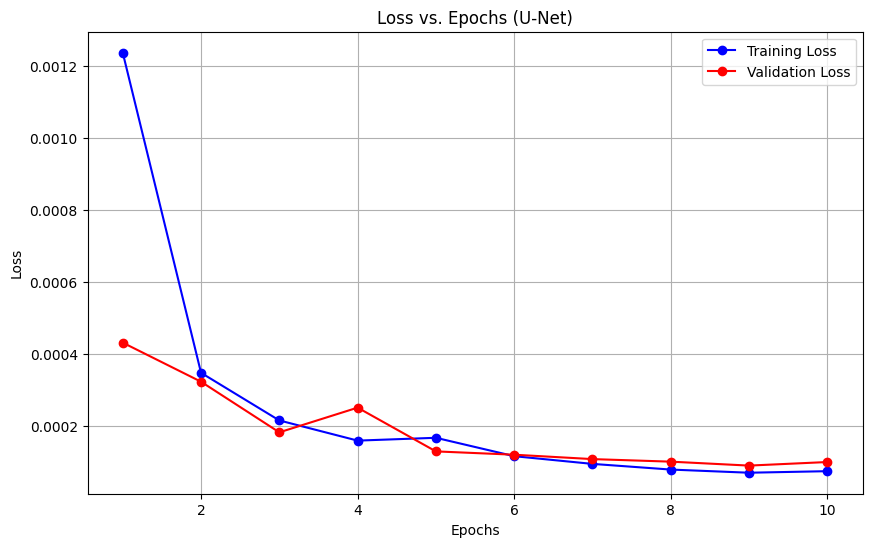

In [12]:
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss vs. Epochs (U-Net)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

100%|██████████| 400/400 [05:06<00:00,  1.30it/s]


Average enhanced SSIM: 0.931866
Average enhanced PSNR: 31.129311
Average initial SSIM: 0.387060
Average initial PSNR: 9.708573


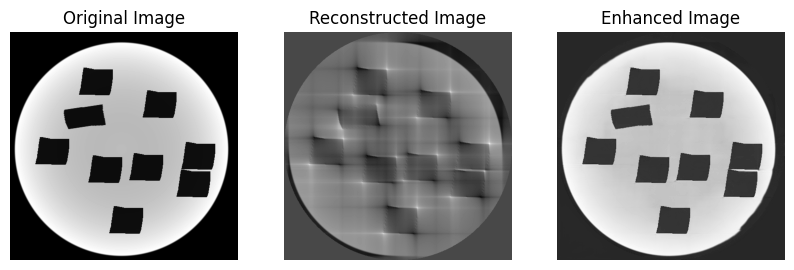

In [11]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate SSIM for a batch of images
def batch_ssim(enhanced_images, ground_truth_images):
    ssim_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = ssim(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Function to calculate PSNR for a batch of images
def batch_psnr(enhanced_images, ground_truth_images):
    psnr_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = psnr(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in tqdm(test_data_loader):
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average enhanced SSIM: {avg_ssim:.6f}')
print(f'Average enhanced PSNR: {avg_psnr:.6f}')
print(f'Average initial SSIM: {rec_ssim:.6f}')
print(f'Average initial PSNR: {rec_psnr:.6f}')